In [1]:
import pathlib

import gpytorch
from matplotlib import pyplot as plt
import numpy as np
import torch
from torcheval.metrics.functional import r2_score

from mbrl.models import Model
from src.env.bikes import Bikes

%matplotlib inline
%load_ext autoreload
%autoreload 2

### 1. Load env dataset and preprocess

In [2]:
load_dir = "datasets/Bikes/None"
path = pathlib.Path(load_dir) / "replay_buffer.npz"
buffer=np.load(path)
next_obs = torch.tensor(buffer["next_obs"], dtype=torch.float32)
obs = torch.tensor(buffer["obs"], dtype=torch.float32)
act = torch.round(torch.tensor(buffer["action"], dtype=torch.float32))
reward = torch.tensor(buffer["reward"], dtype=torch.float32)
print(obs.shape, act.shape)

num_centroids = 43
map_obs = {
    "bikes_distr": slice(0, num_centroids),
    "day": slice(num_centroids, 44),
    "month": slice(44, 45),
    "time_counter": slice(45, 46),
}
num_trucks = act.shape[-1]//2
map_act={
    "truck_centroid": slice(0, num_trucks),
    "truck_num_bikes": slice(num_trucks, 2*num_trucks),
}

print(map_obs, map_act)

torch.Size([10000, 46]) torch.Size([10000, 10])
{'bikes_distr': slice(0, 43, None), 'day': slice(43, 44, None), 'month': slice(44, 45, None), 'time_counter': slice(45, 46, None)} {'truck_centroid': slice(0, 5, None), 'truck_num_bikes': slice(5, 10, None)}


Compute delta bikes and obs += delta_bikes

In [3]:
obs_before_action = obs.clone()

resize = False
while obs.ndim < 3:
    assert act.ndim == obs.ndim
    obs = obs[None, ...]
    act = act[None, ...]
    resize = True

ensemble_size = obs.shape[0]
batch_size = obs.shape[1]
distr_size = len(obs[0, 0, map_obs["bikes_distr"]]) #self.map_obs["bikes_distr"]

# Compute delta_bikes in a parallel way
delta_bikes = np.zeros((ensemble_size, batch_size, distr_size), dtype=int)
truck_centroids = act[..., map_act["truck_centroid"]] #self.map_act["truck_centroid"]
truck_bikes = act[..., map_act["truck_num_bikes"]] #self.map_act["truck_num_bikes"]
n = distr_size
truck_centroids = np.reshape(
    truck_centroids, (truck_centroids.shape[0] * truck_centroids.shape[1], -1)
)
offset = np.arange(truck_centroids.shape[0])[..., None]
truck_centroids_offset = truck_centroids + offset * n
unq, inv = np.unique(truck_centroids_offset.ravel(), return_inverse=True)
unq = unq.astype(int)
sol = np.bincount(inv, truck_bikes.ravel())
delta_bikes[
    unq // (batch_size * n),
    (unq % (batch_size * n)) // n,
    (unq % (batch_size * n)) % n,
] = sol

if resize:
    delta_bikes = delta_bikes.reshape((batch_size, -1))
    act = act.reshape((batch_size, -1))
    obs = obs.reshape((batch_size, -1))

# Update obs
obs[..., map_obs["bikes_distr"]] += delta_bikes #self.map_obs["bikes_distr"]

print(torch.sum(obs-obs_before_action, axis=-1))
print(torch.sum(act[...,map_act["truck_num_bikes"]], axis=-1))

assert torch.all(torch.sum(obs-obs_before_action, axis=-1) == torch.sum(act[...,map_act["truck_num_bikes"]], axis=-1))

# Super long check to see if preprocess is good, and it is so far
for obs_, previous_obs_, truck_centroids, truck_num_bikes in zip(obs, obs_before_action, act[...,map_act["truck_centroid"]], act[...,map_act["truck_num_bikes"]]):
    bikes_idx = torch.nonzero(truck_num_bikes, as_tuple=True)[0]
    truck_centroids = truck_centroids[bikes_idx]
    centroids_new_bikes = torch.nonzero(obs_-previous_obs_, as_tuple=True)[0]
    # print(torch.sort(centroids_new_bikes).values)
    # print(torch.unique(truck_centroids))
    # print(torch.sort(centroids_new_bikes).values in torch.unique(truck_centroids))
    assert torch.sort(centroids_new_bikes).values in torch.unique(truck_centroids)


tensor([13., 10., 18.,  ..., 11., 13., 10.])
tensor([13., 10., 18.,  ..., 11., 13., 10.])


Create x and y from obs and next_obs

In [4]:
dataset_size = 10000
input_obs_keys = ["bikes_distr", "time_counter"]
input_act_keys = [] #not implemented
output_keys = ["bikes_distr"]

input_mask = np.zeros(obs.shape[-1])
for key in input_obs_keys:
    input_mask[map_obs[key]] = 1
input_mask = np.ma.make_mask(input_mask)

output_mask = np.zeros(obs.shape[-1])
for key in output_keys:
    output_mask[map_obs[key]] = 1
output_mask = np.ma.make_mask(output_mask)

assert obs.ndim == 2
assert next_obs.ndim == 2
x = obs[:dataset_size, input_mask]
y = next_obs[:dataset_size, output_mask]

print(x.shape, y.shape)

torch.Size([10000, 44]) torch.Size([10000, 43])


Additional input features

In [5]:
#Maybe add a date proxy, weather ? holiday, week-end ??

Additional output preds (e.g. reward)

In [6]:
learned_rewards = True
if learned_rewards:
    reward_ = reward[:dataset_size, ...].unsqueeze(-1)
    print(y.shape, reward_.shape)
    y = torch.cat([y, reward_], dim=-1)
    print(y.shape)

torch.Size([10000, 43]) torch.Size([10000, 1])
torch.Size([10000, 44])


Split into train_x, test_x and train_y, test_y

In [7]:
test_split_ratio = 0.2

# torch.manual_seed(0)
# idx = torch.randperm(x.shape[0])
# x = x[idx, :]
# y = y[idx, :]

train_x = x[int(test_split_ratio*dataset_size):, ...]
train_y = y[int(test_split_ratio*dataset_size):, ...]
test_x = x[:int(test_split_ratio*dataset_size), ...]
test_y = y[:int(test_split_ratio*dataset_size), ...]

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([8000, 44]) torch.Size([8000, 44]) torch.Size([2000, 44]) torch.Size([2000, 44])


### 2. Train model

Linear regression

In [9]:
from src.model.linear_regression import LinearRegression

learningRate = 0.01 
epochs = 2000
eval_epoch_freq = 1
in_size=train_x.shape[-1]
out_size=train_y.shape[-1]
device="cpu"
lr_model = LinearRegression(in_size, out_size, device)
criterion = torch.nn.MSELoss()
metric = r2_score
optimizer = torch.optim.SGD(lr_model.parameters(), lr=learningRate)

In [17]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    torch.manual_seed(epoch)
    idx = torch.randperm(train_x.shape[0])
    train_x = train_x[idx, :]
    train_y = train_y[idx, :]
    idx = torch.randperm(test_x.shape[0])
    test_x = test_x[idx, :]
    test_y = test_y[idx, :]
    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = lr_model(train_x)

    # get loss for the predicted output
    loss = criterion(outputs, train_y)
    train_losses.append(loss.item())
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    #Compute metric
    train_metric = metric(outputs, train_y)
    train_metrics.append(train_metric)

    print('epoch {}, loss {}, R2 {}'.format(epoch, loss.item(), train_metric))

    if epoch%eval_epoch_freq==0:
        with torch.no_grad(): # we don't need gradients in the testing phase
            preds = lr_model(test_x)
            test_loss = criterion(preds, test_y)
            test_losses.append(test_loss.item())
            #Compute metric
            test_metric = metric(preds, test_y)
            test_metrics.append(test_metric)
            print('Eval loss {}, R2 {}'.format(test_loss.item(), test_metric))


epoch 0, loss 7.188284873962402, R2 -2.206334352493286
Eval loss 6.941813945770264, R2 -1.9536854028701782
epoch 1, loss 6.912776947021484, R2 -2.1389591693878174
Eval loss 6.691708087921143, R2 -1.8928974866867065
epoch 2, loss 6.661588191986084, R2 -2.0771067142486572
Eval loss 6.463588714599609, R2 -1.8370894193649292
epoch 3, loss 6.432467460632324, R2 -2.0202696323394775
Eval loss 6.255420684814453, R2 -1.785797119140625
epoch 4, loss 6.223369121551514, R2 -1.9679820537567139
Eval loss 6.065353870391846, R2 -1.7386103868484497
epoch 5, loss 6.03244161605835, R2 -1.919825792312622
Eval loss 5.891716480255127, R2 -1.695146083831787
epoch 6, loss 5.858002185821533, R2 -1.8754196166992188
Eval loss 5.732985973358154, R2 -1.6550629138946533
epoch 7, loss 5.698524475097656, R2 -1.8344193696975708
Eval loss 5.587784767150879, R2 -1.6180499792099
epoch 8, loss 5.5526251792907715, R2 -1.7965086698532104
Eval loss 5.454861640930176, R2 -1.5838249921798706
epoch 9, loss 5.419047832489014, R2

<Figure size 640x480 with 0 Axes>

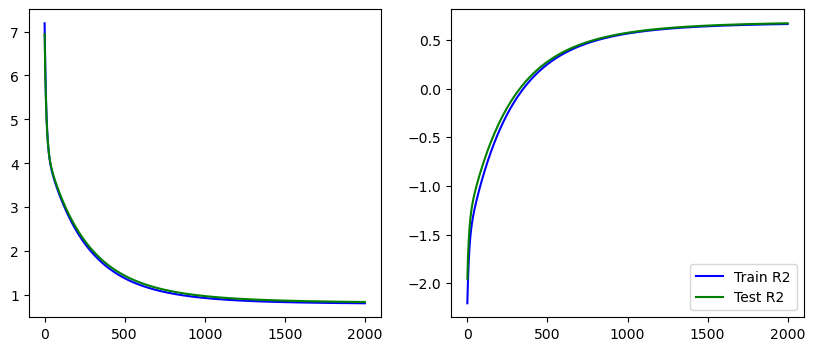

In [18]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, 'b', label='Training loss')
ax[0].plot(test_losses, 'g', label='Test loss')
ax[1].plot(train_metrics, 'b', label='Train R2')
ax[1].plot(test_metrics, 'g', label='Test R2')
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 0 Axes>

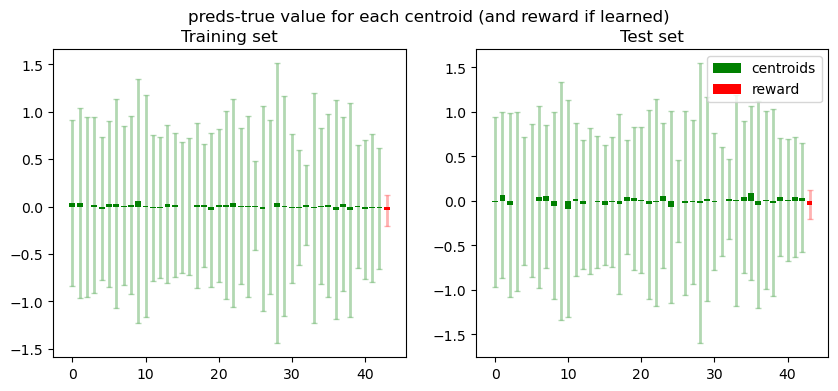

In [19]:
with torch.no_grad(): # we don't need gradients in the testing phase
    train_preds = lr_model(train_x)
    test_preds = lr_model(test_x)

relative_train_preds_mean = torch.mean(train_preds - train_y, axis=0)
relative_train_preds_std = torch.std(train_preds - train_y, axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y, axis=0)
relative_test_preds_std = torch.std(test_preds - test_y, axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#Colors and labels
if len(relative_train_preds_mean)<num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean)==num_centroids:
    color="green"
    label='centroids'
else:
    colors=["green"]*num_centroids
    colors.append("red")
    label=["centroids"]*num_centroids
    label.append("reward")

#Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(
    x,
    relative_train_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_train_preds_mean, relative_train_preds_std, colors):
    ax[0].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text('Training set')

#Test bar plots
ax[1].bar(
    x,
    relative_test_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_test_preds_mean, relative_test_preds_std, colors):
    ax[1].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
ax[1].title.set_text('Test set')

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()

With model trainer

In [10]:
#TEST with model trainer
import omegaconf

from src.env.bikes import Bikes
from src.model.dict_model_wrapper import OneDTransitionRewardModelDictSpace
from src.util.model_trainer import ModelTrainerOverriden
from src.util.replay_buffer import ReplayBufferOverriden
import mbrl.util.common

#WARNING: Make sure that it makes sense with trained model above

#Env config
env_config = {
    "num_trucks": 5, #10
    "action_per_day": 8,
    "next_day_method": "random", #sequential
    "initial_distribution": "zeros",
    "bikes_per_truck": 5,
    "start_walk_dist_max": 0.2,
    "end_walk_dist_max": 1000.,
    "trip_duration": 0.5,
    "past_trip_data": "src/env/bikes_data/all_trips_LouVelo_merged.csv",
    "weather_data": "src/env/bikes_data/weather_data.csv",
    "centroids_coord": "src/env/bikes_data/LouVelo_centroids_coords.npy",
    #"centroids_idx": #[93,83,80,98,6,84,87,99,56,97], #Number of centroids or list of indices
    "station_dependencies": None, #src/env/bikes_data/factors_radius_3.npy
}

#Params
seed = 1
device = "cpu"
target_is_delta = False
normalize = False
use_double_dtype = False #True
optim_lr=0.01 #learningRate
model_wd=0.
model_batch_size=256 #dataset_size
validation_ratio=test_split_ratio
num_epochs= 200 #epochs

#Env
env_config = omegaconf.DictConfig(env_config)
env = Bikes(
    env_config,
    render_mode=None
)

obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

#Seed
# rng = np.random.default_rng(seed=seed)
# torch_generator = torch.Generator(device=device)
# if seed is not None:
#     torch_generator.manual_seed(seed)
rng = np.random.default_rng(seed=0)
torch.manual_seed(0)

#Dynamics model
from src.model.simple import Simple
from src.model.gaussian_process import MultiOutputGP
dynamics_model = OneDTransitionRewardModelDictSpace(
    MultiOutputGP(in_size, out_size, device),
    map_obs=env.map_obs,
    map_act=env.map_act,
    rescale_obs=env.rescale_obs,
    rescale_act=env.rescale_act,
    model_input_obs_key=input_obs_keys,
    model_input_act_key=input_act_keys,
    model_output_key=output_keys,
    obs_preprocess_fn=env.obs_preprocess_fn,
    obs_postprocess_fn=env.obs_postprocess_fn,
    target_is_delta=target_is_delta,
    normalize=normalize,
    normalize_double_precision=use_double_dtype,
    learned_rewards=learned_rewards,
    no_delta_list=None,
    num_elites=None,
)

#Model trainer
model_trainer = ModelTrainerOverriden(
    model=dynamics_model,
    optim_lr=optim_lr,
    weight_decay=model_wd,
    logger=None,
)

#Load replay Buffer
dtype = np.double if use_double_dtype else np.float32
replay_buffer = ReplayBufferOverriden(
    dataset_size,
    obs_shape,
    act_shape,
    obs_type=dtype,
    action_type=dtype,
    reward_type=dtype,
    rng=rng,
    #max_trajectory_length=None,
)

load_dir = pathlib.Path(load_dir)
replay_buffer.load(str(load_dir), num_to_store=dataset_size)

dataset_train, dataset_val = mbrl.util.common.get_basic_buffer_iterators(
    replay_buffer,
    model_batch_size,
    validation_ratio,
    ensemble_size=len(dynamics_model),
    shuffle_each_epoch=True,
    bootstrap_permutes=False,
)

if hasattr(dynamics_model, "update_normalizer"):
    dynamics_model.update_normalizer(replay_buffer.get_all())
train_losses, test_losses, train_metrics, test_metrics = model_trainer.train(
    dataset_train,
    dataset_val,
    num_epochs=num_epochs,
    patience=num_epochs,
    evaluate=True,
    debug=True,
)

Training epoch duration: 22.04s
Epoch: 0 Train loss 2.778, Test loss 4.743 
Training epoch duration: 20.56s
Epoch: 1 Train loss 2.455, Test loss 4.393 


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

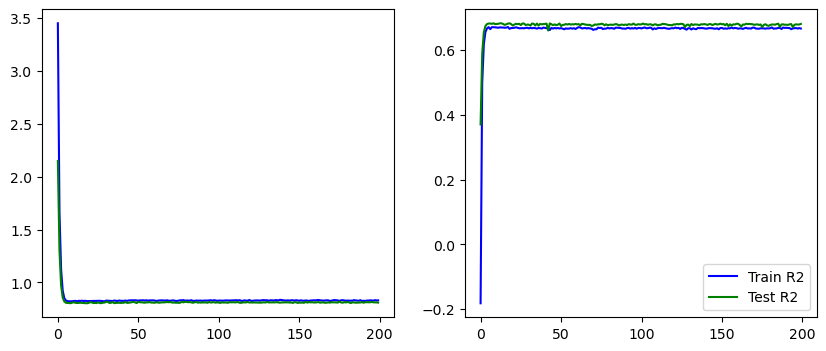

In [47]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, 'b', label='Training loss')
ax[0].plot(test_losses, 'g', label='Test loss')
ax[1].plot(train_metrics, 'b', label='Train R2')
ax[1].plot(test_metrics, 'g', label='Test R2')
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 0 Axes>

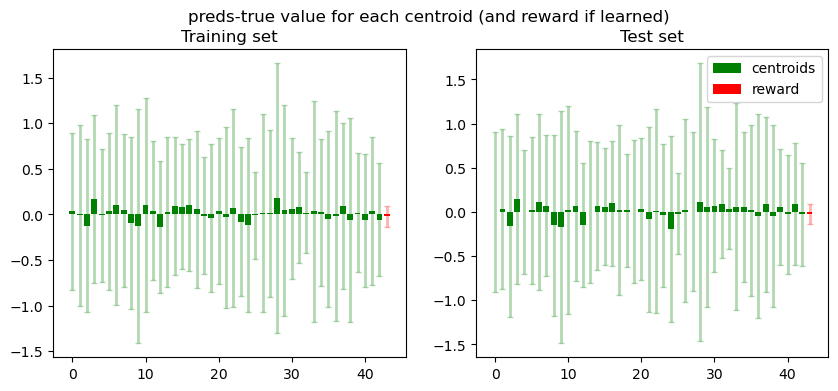

In [48]:
with torch.no_grad(): # we don't need gradients in the testing phase
    train_preds = dynamics_model.model(train_x)
    test_preds = dynamics_model.model(test_x)

relative_train_preds_mean = torch.mean(train_preds - train_y, axis=0)
relative_train_preds_std = torch.std(train_preds - train_y, axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y, axis=0)
relative_test_preds_std = torch.std(test_preds - test_y, axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#Colors and labels
if len(relative_train_preds_mean)<num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean)==num_centroids:
    color="green"
    label='centroids'
else:
    colors=["green"]*num_centroids
    colors.append("red")
    label=["centroids"]*num_centroids
    label.append("reward")

#Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(
    x,
    relative_train_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_train_preds_mean, relative_train_preds_std, colors):
    ax[0].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text('Training set')

#Test bar plots
ax[1].bar(
    x,
    relative_test_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_test_preds_mean, relative_test_preds_std, colors):
    ax[1].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
ax[1].title.set_text('Test set')

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()

Neural Network

In [159]:
from src.model.simple import Simple

#Hyperparams
learningRate = 0.001
weight_decay = 0
optim_eps = 1e-8

epochs = 500
batch_size = 256
eval_epoch_freq = 1
in_size=train_x.shape[-1]
out_size=train_y.shape[-1]
device="cpu"
NN_model = Simple(in_size, out_size, device)
criterion = torch.nn.MSELoss()
metric = r2_score
optimizer = torch.optim.Adam(
                NN_model.parameters(),
                lr=learningRate,
                weight_decay=weight_decay,
                eps=optim_eps,
            )
#torch.optim.SGD(model.parameters(), lr=learningRate)

In [160]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    k = 0
    l = batch_size
    batch_loss = []
    while l < train_x.shape[0]:
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = NN_model(train_x)

        # get loss for the predicted output
        loss = criterion(outputs, train_y)
        batch_loss.append(loss.item())
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        #Update k,l
        k = l
        l = min(l+batch_size, train_x.shape[0])

    #Append train loss
    train_losses.append(np.mean(batch_loss))

    #Compute metric
    train_metric = metric(outputs, train_y)
    train_metrics.append(train_metric)

    print('epoch {}, loss {}, R2 {}'.format(epoch, loss.item(), train_metric))

    if epoch%eval_epoch_freq==0:
        with torch.no_grad(): # we don't need gradients in the testing phase
            preds = NN_model(test_x)
            test_loss = criterion(preds, test_y)
            test_losses.append(test_loss.item())
            #Compute metric
            test_metric = metric(preds, test_y)
            test_metrics.append(test_metric)
            print('Eval loss {}, R2 {}'.format(test_loss.item(), test_metric))

epoch 0, loss 5.323896408081055, R2 -0.4018963575363159
Eval loss 5.323896408081055, R2 -0.40800949931144714
epoch 1, loss 4.939913272857666, R2 -0.25594255328178406
Eval loss 4.939913272857666, R2 -0.18786725401878357
epoch 2, loss 3.9092791080474854, R2 -0.16295231878757477
Eval loss 3.9092791080474854, R2 -0.604037344455719
epoch 3, loss 3.834420680999756, R2 -0.7803119421005249
Eval loss 3.834420680999756, R2 -0.4473435580730438
epoch 4, loss 3.371290445327759, R2 0.05224437639117241
Eval loss 3.371290445327759, R2 0.07332278043031693
epoch 5, loss 3.4254508018493652, R2 0.06424520909786224
Eval loss 3.4254508018493652, R2 0.05064111575484276
epoch 6, loss 3.348079204559326, R2 0.045901037752628326
Eval loss 3.348079204559326, R2 0.02455156482756138
epoch 7, loss 3.3848602771759033, R2 0.025363124907016754
Eval loss 3.3848602771759033, R2 0.016881713643670082
epoch 8, loss 3.3062312602996826, R2 0.046125736087560654
Eval loss 3.3062312602996826, R2 0.04103560000658035
epoch 9, loss

<Figure size 640x480 with 0 Axes>

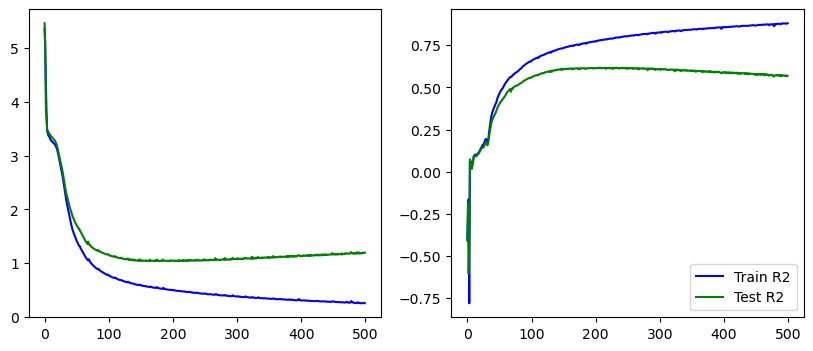

In [161]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, 'b', label='Training loss')
ax[0].plot(test_losses, 'g', label='Test loss')
ax[1].plot(train_metrics, 'b', label='Train R2')
ax[1].plot(test_metrics, 'g', label='Test R2')
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 0 Axes>

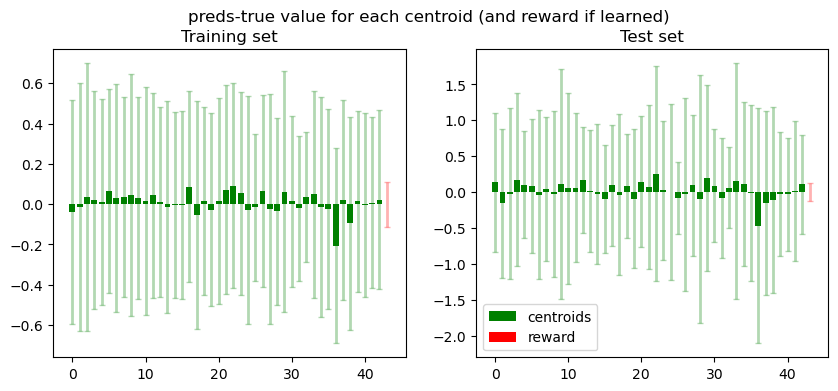

In [162]:
with torch.no_grad(): # we don't need gradients in the testing phase
    train_preds = NN_model(train_x)
    test_preds = NN_model(test_x)

relative_train_preds_mean = torch.mean(train_preds - train_y, axis=0)
relative_train_preds_std = torch.std(train_preds - train_y, axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y, axis=0)
relative_test_preds_std = torch.std(test_preds - test_y, axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#Colors and labels
if len(relative_train_preds_mean)<num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean)==num_centroids:
    color="green"
    label='centroids'
else:
    colors=["green"]*num_centroids
    colors.append("red")
    label=["centroids"]*num_centroids
    label.append("reward")

#Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(
    x,
    relative_train_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_train_preds_mean, relative_train_preds_std, colors):
    ax[0].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text('Training set')

#Test bar plots
ax[1].bar(
    x,
    relative_test_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_test_preds_mean, relative_test_preds_std, colors):
    ax[1].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
ax[1].title.set_text('Test set')

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()

Gaussian process

In [14]:
from src.model.gaussian_process import MultiOutputGP

#Hyperparams
learningRate = 0.1
weight_decay = 0
optim_eps = 1e-8
mean = "Linear"
kernel = "Linear"

epochs = 50
eval_epoch_freq = 1
in_size=train_x.shape[-1]
out_size=train_y.shape[-1]
device="cpu"
GP_model = MultiOutputGP(in_size, out_size, device, mean, kernel)
mll = gpytorch.mlls.SumMarginalLogLikelihood(GP_model.likelihood, GP_model.gp)
metric = r2_score
optimizer = torch.optim.Adam(
                GP_model.parameters(),
                lr=learningRate,
                weight_decay=weight_decay,
                eps=optim_eps,
            )
#torch.optim.SGD(model.parameters(), lr=learningRate)

dataset_size_gp = 1000
gp_idx_split = int(test_split_ratio*dataset_size_gp)

train_x_gp = train_x[gp_idx_split:dataset_size_gp, ...]
train_y_gp = train_y[gp_idx_split:dataset_size_gp, ...]
test_x_gp = test_x[:gp_idx_split, ...]
test_y_gp = test_y[:gp_idx_split, ...]

print(train_x_gp.shape, train_y_gp.shape, test_x_gp.shape, test_y_gp.shape)

torch.Size([800, 44]) torch.Size([800, 44]) torch.Size([200, 44]) torch.Size([200, 44])


In [15]:
train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
for epoch in range(epochs):
    #Set training mode REQUIRED FOR GP
    GP_model.gp.train()

    #Set the training data
    if epoch==0:
        GP_model.set_train_data(train_x_gp, train_y_gp)

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = GP_model.forward()

    # get loss for the predicted output
    loss = -mll(outputs, GP_model.gp.train_targets)
    train_losses.append(loss.item())
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    #Compute metric
    train_pred_output = GP_model.likelihood(*outputs)
    train_pred_mean = torch.cat(
        [pred.mean.unsqueeze(-1) for pred in train_pred_output], axis=-1
    )
    train_metric = metric(train_pred_mean, train_y_gp)
    train_metrics.append(train_metric)

    print('epoch {}, loss {}, R2 {}'.format(epoch, loss.item(), train_metric))

    if epoch%eval_epoch_freq==0:
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            GP_model.gp.eval()
            GP_model.likelihood.eval()
            preds = GP_model.forward(test_x_gp)
            test_loss = -mll(preds, [test_y_gp[..., i] for i in range(len(GP_model.gp.models))])
            test_losses.append(test_loss.item())
            #Compute metric
            test_pred_output = GP_model.likelihood(*preds)
            test_pred_mean = torch.cat(
                [pred.mean.unsqueeze(-1) for pred in test_pred_output], axis=-1
            )
            test_metric = metric(test_pred_mean, test_y_gp)
            test_metrics.append(test_metric)
            print('Eval loss {}, R2 {}'.format(test_loss.item(), test_metric))

epoch 0, loss 1.6078085899353027, R2 -229.49391174316406


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

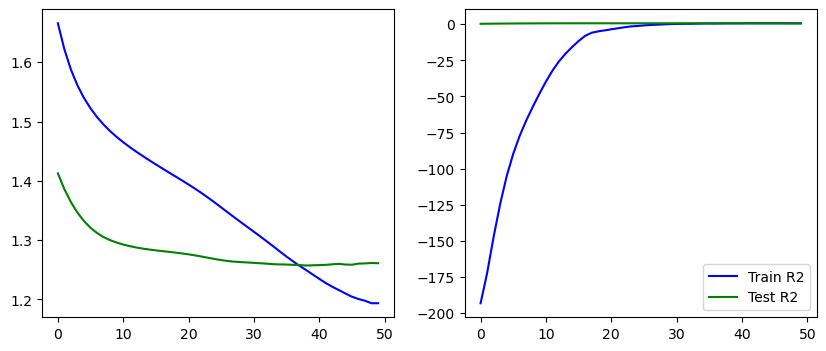

In [165]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, 'b', label='Training loss')
ax[0].plot(test_losses, 'g', label='Test loss')
ax[1].plot(train_metrics, 'b', label='Train R2')
ax[1].plot(test_metrics, 'g', label='Test R2')
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 0 Axes>

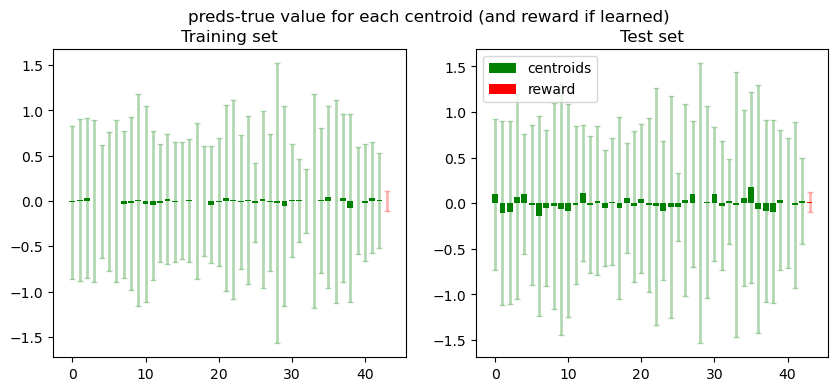

In [166]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_preds = GP_model.likelihood(*GP_model(train_x_gp))
    test_preds = GP_model.likelihood(*GP_model(test_x_gp))
    train_preds = torch.cat(
        [pred.mean.unsqueeze(-1) for pred in train_preds], axis=-1
    )
    test_preds = torch.cat(
        [pred.mean.unsqueeze(-1) for pred in test_preds], axis=-1
    )

relative_train_preds_mean = torch.mean(train_preds - train_y_gp, axis=0)
relative_train_preds_std = torch.std(train_preds - train_y_gp, axis=0)
relative_test_preds_mean = torch.mean(test_preds - test_y_gp, axis=0)
relative_test_preds_std = torch.std(test_preds - test_y_gp, axis=0)

plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#Colors and labels
if len(relative_train_preds_mean)<num_centroids:
    raise ValueError("Predicted outputs are weird")
if len(relative_train_preds_mean)==num_centroids:
    color="green"
    label='centroids'
else:
    colors=["green"]*num_centroids
    colors.append("red")
    label=["centroids"]*num_centroids
    label.append("reward")

#Train bar plots
x = torch.arange(0, len(relative_train_preds_mean), 1)
ax[0].bar(
    x,
    relative_train_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_train_preds_mean, relative_train_preds_std, colors):
    ax[0].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
    # error_kw=dict(ecolor=colors, lw=1, capsize=1, capthick=2, alpha=0.5),
ax[0].title.set_text('Training set')

#Test bar plots
ax[1].bar(
    x,
    relative_test_preds_mean,
    color=colors,
    label=label
)
for pos, y, err, color in zip(x, relative_test_preds_mean, relative_test_preds_std, colors):
    ax[1].errorbar(pos, y, err, lw = 2,capsize = 2, capthick = 1, color = color, alpha=0.3)
ax[1].title.set_text('Test set')

fig.suptitle("preds-true value for each centroid (and reward if learned)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')
plt.show()

In [167]:
gp_id = 0

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_pred = GP_model.likelihood.likelihoods[gp_id](GP_model.gp.models[gp_id](train_x_gp))
    test_pred = GP_model.likelihood.likelihoods[gp_id](GP_model.gp.models[gp_id](test_x_gp))

    train_lower, train_upper = train_pred.confidence_region()
    mean_lower_train = np.mean(train_lower.numpy()-train_pred.mean.numpy())
    std_lower_train = np.std(train_lower.numpy()-train_pred.mean.numpy())
    mean_upper_train = np.mean(train_upper.numpy()-train_pred.mean.numpy())
    std_upper_train = np.std(train_upper.numpy()-train_pred.mean.numpy())
    test_lower, test_upper = test_pred.confidence_region()
    mean_lower_test = np.mean(test_lower.numpy()-test_pred.mean.numpy())
    std_lower_test = np.std(test_lower.numpy()-test_pred.mean.numpy())
    mean_upper_test = np.mean(test_upper.numpy()-test_pred.mean.numpy())
    std_upper_test = np.std(test_upper.numpy()-test_pred.mean.numpy())

    print(train_pred.mean.numpy().shape, test_pred.mean.numpy().shape)
    print(f"Lower train: {mean_lower_train}+-{std_lower_train}")
    print(f"Upper train: {mean_upper_train}+-{std_upper_train}")
    print(f"Lower train: {mean_lower_test}+-{std_lower_test}")
    print(f"Lower train: {mean_upper_test}+-{std_upper_test}")

(600,) (200,)
Lower train: -1.8210667371749878+-0.01887916587293148
Upper train: 1.8210667371749878+-0.01887916401028633
Lower train: -1.8232992887496948+-0.018743911758065224
Lower train: 1.8232992887496948+-0.01874392479658127


### 3. The MBRL agent

Parameters

In [51]:
import omegaconf

import mbrl
import mbrl.models
import mbrl.planning
from src.env.bikes import Bikes
from src.model.dict_model_wrapper import OneDTransitionRewardModelDictSpace

#WARNING: Make sure that it makes sense with trained model above

#Env config
env_config = {
    "num_trucks": 5, #10
    "action_per_day": 8,
    "next_day_method": "random", #sequential
    "initial_distribution": "zeros",
    "bikes_per_truck": 5,
    "start_walk_dist_max": 0.2,
    "end_walk_dist_max": 1000.,
    "trip_duration": 0.5,
    "past_trip_data": "src/env/bikes_data/all_trips_LouVelo_merged.csv",
    "weather_data": "src/env/bikes_data/weather_data.csv",
    "centroids_coord": "src/env/bikes_data/LouVelo_centroids_coords.npy",
    #"centroids_idx": #[93,83,80,98,6,84,87,99,56,97], #Number of centroids or list of indices
    "station_dependencies": None, #src/env/bikes_data/factors_radius_3.npy
}

#Params
seed = 0
device = "cpu"
num_episodes = 10
num_steps = num_episodes*env_config["action_per_day"]
initial_exploration_steps = 500
target_is_delta = False
normalize = False
use_double_dtype = False #True
num_particles = 20

#Agent config
optimizer_cfg = {
    "_target_": "mbrl.planning.CEMOptimizer",
    "num_iterations": 5,
    "elite_ratio": 0.1,
    "population_size": 350,
    "alpha": 0.1,
    "lower_bound": None,
    "upper_bound": None,
    "return_mean_elites": True,
    "device": device,
    "clipped_normal": False,
}


The important building blocks

In [52]:
#Env
env_config = omegaconf.DictConfig(env_config)
env = Bikes(
    env_config,
    render_mode=None
)

obs_shape = env.observation_space.shape
act_shape = env.action_space.shape
print(obs_shape, act_shape)

#Seed
rng = np.random.default_rng(seed=seed)
torch_generator = torch.Generator(device=device)
if seed is not None:
    torch_generator.manual_seed(seed)

#Dynamics model
model = lr_model

dynamics_model = OneDTransitionRewardModelDictSpace(
    model,
    map_obs=env.map_obs,
    map_act=env.map_act,
    rescale_obs=env.rescale_obs,
    rescale_act=env.rescale_act,
    model_input_obs_key=input_obs_keys,
    model_input_act_key=input_act_keys,
    model_output_key=output_keys,
    obs_preprocess_fn=env.obs_preprocess_fn,
    obs_postprocess_fn=env.obs_postprocess_fn,
    target_is_delta=target_is_delta,
    normalize=normalize,
    normalize_double_precision=use_double_dtype,
    learned_rewards=learned_rewards,
    no_delta_list=None,
    num_elites=None,
)

#Model Env
model_env = mbrl.models.ModelEnv(
    env, dynamics_model, env.termination_fn, None, generator=torch_generator
)

#Agent
optimizer_cfg = omegaconf.DictConfig(optimizer_cfg)
agent = mbrl.planning.TrajectoryOptimizerAgent(
    optimizer_cfg=optimizer_cfg,
    action_lb=env.action_space.low,
    action_ub=env.action_space.high,
    planning_horizon=env.action_per_day,
    replan_freq=1,
)
def trajectory_eval_fn(initial_state, action_sequences):
    return model_env.evaluate_action_sequences(
        action_sequences, initial_state=initial_state, num_particles=num_particles
    )
agent.set_trajectory_eval_fn(trajectory_eval_fn)


(46,) (10,)


RL loop (with pretrained model)

In [55]:
import warnings
warnings.filterwarnings("ignore")

env_steps = 0
current_trial = 0
rewards = np.empty((num_episodes, env_config["action_per_day"]))

while (
    current_trial < num_episodes
):
    obs, _ = env.reset()
    agent.reset()
    terminated = False
    truncated = False
    total_reward = 0.0
    steps_trial = 0

    # Make 1 episode
    while not terminated and not truncated:

        # --- Doing env step using the agent ---
        action = agent.act(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        rewards[current_trial, steps_trial] = reward

        obs = next_obs
        total_reward += reward
        steps_trial += 1
        env_steps += 1
        
        #print(f"Step {env_steps}: Reward {reward:.3f}.")

    current_trial += 1
    print(f"Trial: {current_trial }, reward: {total_reward}.")

Trial: 1, reward: 2.573672088377971.
Trial: 2, reward: 2.705402098585997.
Trial: 3, reward: 2.322563968184047.
Trial: 4, reward: 2.677491420881591.
Trial: 5, reward: 2.8242376956986925.
Trial: 6, reward: 3.101734248162826.
Trial: 7, reward: 1.843696885892893.
Trial: 8, reward: 1.903616935018447.
Trial: 9, reward: 2.8298462815498127.
Trial: 10, reward: 2.7504850048228.


Text(0, 0.5, 'Cumulative Reward')

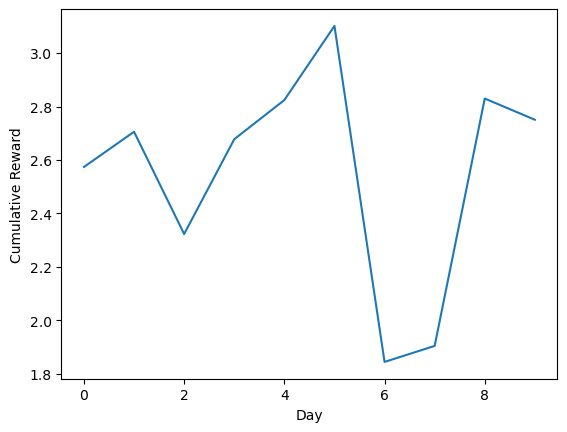

In [56]:
plt.plot(np.sum(rewards, axis=-1))
plt.xlabel('Day'); plt.ylabel('Cumulative Reward')

### 4. Training MBRL agent with a pretrained model

Parameters

In [104]:
from typing import Optional
import omegaconf

import mbrl
import mbrl.models
import mbrl.planning
from mbrl.models.model import Model
from mbrl.util.logger import Logger
import mbrl.util.common
import mbrl.models

from src.util.replay_buffer import ReplayBufferOverriden
from src.util.model_trainer import ModelTrainer, ModelTrainerOverriden
from src.env.bikes import Bikes
from src.model.dict_model_wrapper import OneDTransitionRewardModelDictSpace
from src.model.simple import Simple

#WARNING: Make sure that it makes sense with trained model above

#Env config
env_config = {
    "num_trucks": 5, #10
    "action_per_day": 8,
    "next_day_method": "random", #sequential
    "initial_distribution": "zeros",
    "bikes_per_truck": 5,
    "start_walk_dist_max": 0.2,
    "end_walk_dist_max": 1000.,
    "trip_duration": 0.5,
    "past_trip_data": "src/env/bikes_data/all_trips_LouVelo_merged.csv",
    "weather_data": "src/env/bikes_data/weather_data.csv",
    "centroids_coord": "src/env/bikes_data/LouVelo_centroids_coords.npy",
    #"centroids_idx": #[93,83,80,98,6,84,87,99,56,97], #Number of centroids or list of indices
    "station_dependencies": None, #src/env/bikes_data/factors_radius_3.npy
}

#Params
seed = 0
device = "cpu"
num_episodes = 20
num_steps = num_episodes*env_config["action_per_day"]
initial_exploration_steps = 500
target_is_delta = False
normalize = False
use_double_dtype = False #True
num_particles = 20
optim_lr = 0.1
model_wd = 0
freq_train_model = 10
model_batch_size = num_steps+initial_exploration_steps #Make sense for LR or GP
validation_ratio = 0
num_epochs = 25

#Agent config
optimizer_cfg = {
    "_target_": "mbrl.planning.CEMOptimizer",
    "num_iterations": 5,
    "elite_ratio": 0.1,
    "population_size": 350,
    "alpha": 0.1,
    "lower_bound": None,
    "upper_bound": None,
    "return_mean_elites": True,
    "device": device,
    "clipped_normal": False,
}

Important building blocks

In [105]:
#Env
env_config = omegaconf.DictConfig(env_config)
env = Bikes(
    env_config,
    render_mode=None
)

obs_shape = env.observation_space.shape
act_shape = env.action_space.shape
print(obs_shape, act_shape)

#Seed
rng = np.random.default_rng(seed=seed)
torch_generator = torch.Generator(device=device)
if seed is not None:
    torch_generator.manual_seed(seed)

#Dynamics model
model = Simple(in_size, out_size, device)

dynamics_model = OneDTransitionRewardModelDictSpace(
    model,
    map_obs=env.map_obs,
    map_act=env.map_act,
    rescale_obs=env.rescale_obs,
    rescale_act=env.rescale_act,
    model_input_obs_key=input_obs_keys,
    model_input_act_key=input_act_keys,
    model_output_key=output_keys,
    obs_preprocess_fn=env.obs_preprocess_fn,
    obs_postprocess_fn=env.obs_postprocess_fn,
    target_is_delta=target_is_delta,
    normalize=normalize,
    normalize_double_precision=use_double_dtype,
    learned_rewards=learned_rewards,
    no_delta_list=None,
    num_elites=None,
)

#Model Env
model_env = mbrl.models.ModelEnv(
    env, dynamics_model, env.termination_fn, None, generator=torch_generator
)

#Agent
optimizer_cfg = omegaconf.DictConfig(optimizer_cfg)
agent = mbrl.planning.TrajectoryOptimizerAgent(
    optimizer_cfg=optimizer_cfg,
    action_lb=env.action_space.low,
    action_ub=env.action_space.high,
    planning_horizon=env.action_per_day,
    replan_freq=1,
)
def trajectory_eval_fn(initial_state, action_sequences):
    return model_env.evaluate_action_sequences(
        action_sequences, initial_state=initial_state, num_particles=num_particles
    )
agent.set_trajectory_eval_fn(trajectory_eval_fn)

#Model trainer
model_trainer = ModelTrainerOverriden(
    model=dynamics_model,
    optim_lr=optim_lr,
    weight_decay=model_wd,
    logger=None,
)


#Replay Buffer
dtype = np.double if use_double_dtype else np.float32
replay_buffer = ReplayBufferOverriden(
    num_steps+initial_exploration_steps,
    obs_shape,
    act_shape,
    obs_type=dtype,
    action_type=dtype,
    reward_type=dtype,
    rng=rng,
    #max_trajectory_length=None,
)

load_dir = pathlib.Path(load_dir)
replay_buffer.load(str(load_dir), num_to_store=initial_exploration_steps)

(46,) (10,)


Training MBRL loop

In [106]:
import warnings
warnings.filterwarnings("ignore")

env_steps = 0
current_trial = 0
rewards = np.empty((num_episodes, env_config["action_per_day"]))
all_training_losses = []
all_val_scores = []

while current_trial < num_episodes:
    obs, _ = env.reset()
    agent.reset()
    terminated = False
    truncated = False
    total_reward = 0.0
    steps_trial = 0

    # Make 1 episode
    while not terminated and not truncated:
        # --------------- Model Training -----------------
        if env_steps % freq_train_model == 0:
            dataset_train, dataset_val = mbrl.util.common.get_basic_buffer_iterators(
                replay_buffer,
                model_batch_size,
                validation_ratio,
                ensemble_size=len(dynamics_model),
                shuffle_each_epoch=True,
                bootstrap_permutes=False,
            )
            if hasattr(dynamics_model, "update_normalizer"):
                dynamics_model.update_normalizer(replay_buffer.get_all())
            training_losses, val_scores = model_trainer.train(
                dataset_train,
                dataset_val=dataset_val,
                num_epochs=num_epochs,
                patience=num_epochs,
                improvement_threshold=0.01,
            )
            all_training_losses += training_losses
            all_val_scores += val_scores
            print(f"Mean train loss: {np.mean(training_losses):.3f} Mean val score: {np.mean(val_scores):.3f}")

        # --- Doing env step using the agent and adding to model dataset ---
        action = agent.act(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        replay_buffer.add(obs, action, next_obs, reward, terminated, truncated)

        model_action = action[None, ...]
        model_observation = {
            "obs": obs[None, ...],
            "propagation_indices": None,
        }
        model_next_obs, model_reward, model_dones, next_model_state = model_env.step(model_action, model_observation)
        #TODO: compare actual next_obs and rewards with model env
        print(next_obs-torch.round(model_next_obs).numpy(), reward-model_reward.numpy(), terminated)

        rewards[current_trial, steps_trial] = reward

        obs = next_obs
        total_reward += reward
        steps_trial += 1
        env_steps += 1

        print(f"Step {env_steps}: Reward {reward:.3f}.")

    current_trial += 1
    print(f"Trial: {current_trial }, reward: {total_reward}.")


1 500
Epoch: 0 Train loss 5.370, Test loss 864915072.000
1 500
Epoch: 1 Train loss 864915200.000, Test loss 281.795
1 500
Epoch: 2 Train loss 281.795, Test loss 5.353
1 500
Epoch: 3 Train loss 5.353, Test loss 5.373
1 500
Epoch: 4 Train loss 5.373, Test loss 5.311
1 500
Epoch: 5 Train loss 5.311, Test loss 5.156
1 500
Epoch: 6 Train loss 5.156, Test loss 4.905
1 500
Epoch: 7 Train loss 4.905, Test loss 4.582
1 500
Epoch: 8 Train loss 4.582, Test loss 4.256
1 500
Epoch: 9 Train loss 4.256, Test loss 4.038
1 500
Epoch: 10 Train loss 4.038, Test loss 4.029
1 500
Epoch: 11 Train loss 4.029, Test loss 4.146
1 500
Epoch: 12 Train loss 4.146, Test loss 4.144
1 500
Epoch: 13 Train loss 4.144, Test loss 4.023
1 500
Epoch: 14 Train loss 4.023, Test loss 3.897
1 500
Epoch: 15 Train loss 3.897, Test loss 3.841
1 500
Epoch: 16 Train loss 3.841, Test loss 3.855
1 500
Epoch: 17 Train loss 3.855, Test loss 3.906
1 500
Epoch: 18 Train loss 3.906, Test loss 3.956
1 500
Epoch: 19 Train loss 3.956, Test l

<Figure size 640x480 with 0 Axes>

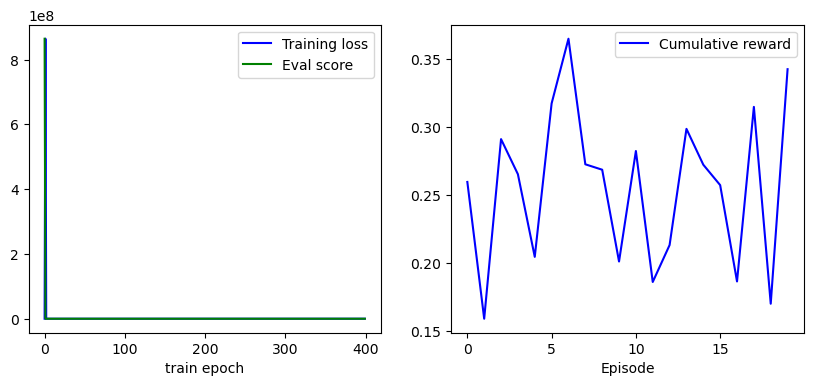

In [107]:
plt.clf()
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(all_training_losses, 'b', label='Training loss')
ax[0].plot(all_val_scores, 'g', label='Eval score')
ax[0].set_xlabel('train epoch')
ax[1].plot(np.mean(rewards, axis=-1), 'b', label='Cumulative reward')
ax[1].set_xlabel('Episode')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.show()